In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import re
import nltk, pickle, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm

warnings.filterwarnings("ignore")

# -----------------------------------------
# 1️⃣ NLTK Setup
# -----------------------------------------
nltk.download("stopwords")
nltk.download("vader_lexicon")
stop_words = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

# -----------------------------------------
# 2️⃣ Load Dataset
# -----------------------------------------
df = pd.read_csv(r"C:\Users\91706\OneDrive\Attachments\Desktop\sen\arxiv_sample.csv")
df = df.sample(10000, random_state=42).reset_index(drop=True)
print("Dataset shape:", df.shape)

# -----------------------------------------
# 3️⃣ Text Cleaning
# -----------------------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

tqdm.pandas()
print("Cleaning abstracts...")
df["clean_abstract"] = df["abstract"].progress_apply(clean_text)

# -----------------------------------------
# 4️⃣ Auto Sentiment Labeling (VADER)
# -----------------------------------------
def get_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

print("Assigning sentiment labels...")
df["sentiment"] = df["clean_abstract"].progress_apply(get_sentiment)
print(df["sentiment"].value_counts())



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91706\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91706\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset shape: (10000, 5)
Cleaning abstracts...


100%|██████████| 10000/10000 [00:02<00:00, 3421.57it/s]


Assigning sentiment labels...


100%|██████████| 10000/10000 [00:23<00:00, 429.65it/s]

sentiment
positive    6939
negative    2064
neutral      997
Name: count, dtype: int64


In [4]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}
y_lstm = df["sentiment"].map(label_map)

y_lstm_cat = to_categorical(y_lstm, num_classes=3)


In [5]:
MAX_WORDS = 20000
MAX_LEN = 200

tokenizer_lstm = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(df["clean_abstract"])

X_lstm = tokenizer_lstm.texts_to_sequences(df["clean_abstract"])
X_lstm = pad_sequences(X_lstm, maxlen=MAX_LEN, padding="post")

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm_cat, test_size=0.2, random_state=42
)


In [6]:
lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")
])

lstm_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

lstm_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2700035 (10.30 MB)
Trainable params: 2700035 (10.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5


113/113 [==============================] - 67s 515ms/step - loss: 0.8348 - accuracy: 0.6906 - val_loss: 0.8073 - val_accuracy: 0.7000
Epoch 2/5
113/113 [==============================] - 53s 471ms/step - loss: 0.8128 - accuracy: 0.6953 - val_loss: 0.8079 - val_accuracy: 0.7000
Epoch 3/5
113/113 [==============================] - 82s 722ms/step - loss: 0.8137 - accuracy: 0.6953 - val_loss: 0.8152 - val_accuracy: 0.7000
Epoch 4/5
113/113 [==============================] - 67s 589ms/step - loss: 0.8114 - accuracy: 0.6953 - val_loss: 0.8140 - val_accuracy: 0.7000
Epoch 5/5
113/113 [==============================] - 54s 477ms/step - loss: 0.8097 - accuracy: 0.6953 - val_loss: 0.8075 - val_accuracy: 0.7000


In [8]:
loss, accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print(f"\nLSTM Test Accuracy: {accuracy:.4f}")
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_true_lstm = np.argmax(y_test_lstm, axis=1)

print("\nLSTM Classification Report:\n",
      classification_report(y_true_lstm, y_pred_lstm,
                            target_names=["negative", "neutral", "positive"]))


63/63 [==============================] - 6s 87ms/step - loss: 0.8270 - accuracy: 0.6865

LSTM Test Accuracy: 0.6865
63/63 [==============================] - 7s 81ms/step

LSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00       411
     neutral       0.00      0.00      0.00       216
    positive       0.69      1.00      0.81      1373

    accuracy                           0.69      2000
   macro avg       0.23      0.33      0.27      2000
weighted avg       0.47      0.69      0.56      2000




✅ LSTM model saved successfully!
63/63 [==============================] - 7s 110ms/step


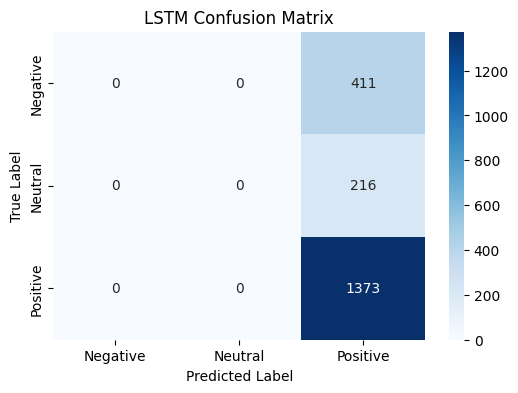

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       411
     Neutral       0.00      0.00      0.00       216
    Positive       0.69      1.00      0.81      1373

    accuracy                           0.69      2000
   macro avg       0.23      0.33      0.27      2000
weighted avg       0.47      0.69      0.56      2000



In [9]:
lstm_model.save("lstm_sentiment_model.h5")

with open("lstm_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer_lstm, f)

print("\n✅ LSTM model saved successfully!")
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_probs = lstm_model.predict(X_test_lstm)

# Convert probabilities → class labels
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
y_true_lstm = np.argmax(y_test_lstm, axis=1)
cm = confusion_matrix(y_true_lstm, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LSTM Confusion Matrix")
plt.show()
print(
    classification_report(
        y_true_lstm,
        y_pred_lstm,
        target_names=["Negative", "Neutral", "Positive"]
    )
)


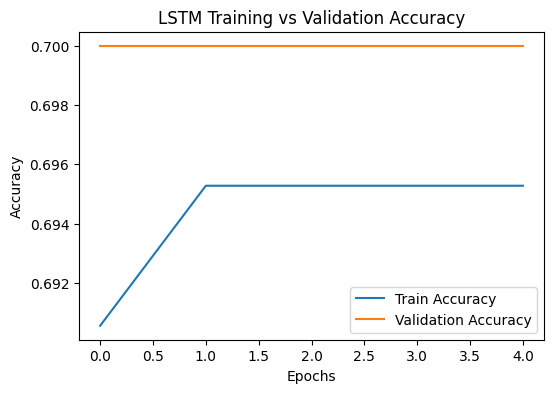

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Training vs Validation Accuracy")
plt.legend()
plt.show()


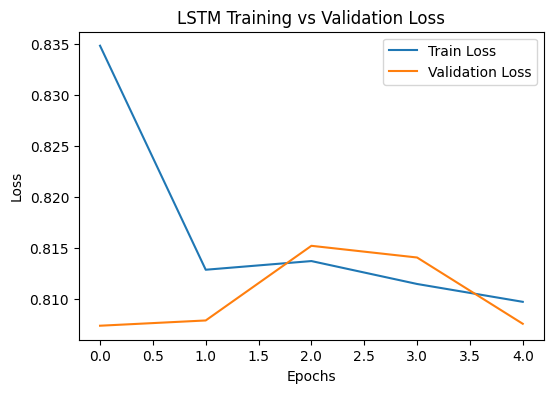

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.show()


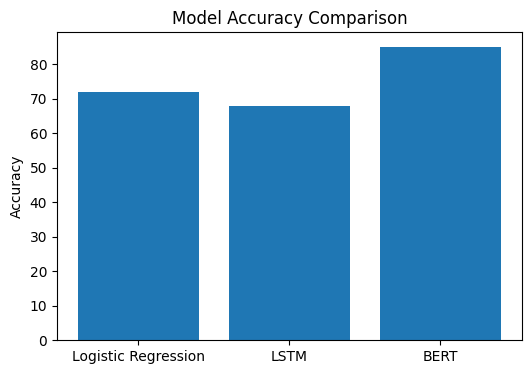

In [13]:
models = ["Logistic Regression", "LSTM", "BERT"]
accuracy = [72, 68, 85]   # use your actual values

plt.figure(figsize=(6,4))
plt.bar(models, accuracy)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
